In [5]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [17]:
random_state = 1095
np.random.seed(1095)

In [20]:
url = "https://whylabs-public.s3.us-west-2.amazonaws.com/whylogs_examples/Ecommerce/baseline_dataset_base.csv"
data = pd.read_csv(url)[["product","category", "rating", "market_price","sales_last_week", "output_discount", "output_prediction", "output_score"]]
data['rating'] = data['rating'].astype(int)

In [398]:
new_label = 2
new_label_frac = 0.2

# Find original confusion types before adding third output
orig_TP = ((data[target_column] == 1) & (data[prediction_column] == 1)).sum() / len(data)
orig_TN = ((data[target_column] == 0) & (data[prediction_column] == 0)).sum() / len(data)
orig_FP = ((data[target_column] == 0) & (data[prediction_column] == 1)).sum() / len(data)
orig_FN = ((data[target_column] == 1) & (data[prediction_column] == 0)).sum() / len(data)

# Change 20% subset to third output (2)
n_change = int(new_label_frac * len(data))
temp_data = data.sample(n=n_change, random_state=random_state)
temp_data["confusion"] = np.random.choice(["TP", "TN", "FP", "FN"], 
                                        n_change,
                                        p=[orig_TP, orig_TN, orig_FP, orig_FN])
new_prediction_idxs = temp_data[temp_data["confusion"].str.get(1) == "P"].index
new_target_idxs = temp_data[temp_data["confusion"] == "FN"].index
data.loc[new_prediction_idxs, prediction_column] = new_label
data.loc[new_target_idxs, target_column] = new_label

In [87]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
from utils import split_data, upload_columnar_segmented_performance_for_past_n_days

In [89]:
segment_columns = ["category", "rating", "output_discount"]
continuous_numerical_columns = ["market_price"]
discrete_numerical_columns = ["sales_last_week", "rating"]
categorical_columns = ["category"]
text_columns = ["product"]

target_column = "output_discount"
prediction_column = "output_prediction"
score_column = "output_score"

split_batches = 7
split_vol_escalation_frac = 0.3
split_vol_noise_frac = 0.1

data = split_data(data, segment_columns, continuous_numerical_columns, discrete_numerical_columns,
                  categorical_columns, text_columns, target_column, prediction_column, score_column,
                   split_batches, split_vol_escalation_frac, split_vol_noise_frac)

result_profiles = upload_columnar_segmented_performance_for_past_n_days(data,
    segment_columns, prediction_column, target_column, score_column, split_batches)

** Profiling segmented performance metrics for column(category) using targets (output_discount) and predictions (output_prediction)
    About to log data for 0 days ago-> 2022-12-12 19:12:43.927545+00:00
    Segmented profile for category on 2022-12-12 19:12:43.927545+00:00 has 11 segments
    Uploading profiles for category on 2022-12-12 19:12:43.927545+00:00, this may take a while...
    Done uploading profiles for category on 2022-12-12 19:12:43.927545+00:00
    About to log data for 1 days ago-> 2022-12-11 19:12:49.696029+00:00
    Segmented profile for category on 2022-12-11 19:12:49.696029+00:00 has 11 segments
    Uploading profiles for category on 2022-12-11 19:12:49.696029+00:00, this may take a while...
    Done uploading profiles for category on 2022-12-11 19:12:49.696029+00:00
    About to log data for 2 days ago-> 2022-12-10 19:12:53.942152+00:00
    Segmented profile for category on 2022-12-10 19:12:53.942152+00:00 has 11 segments
    Uploading profiles for category on 20

<AxesSubplot:xlabel='day', ylabel='Count'>

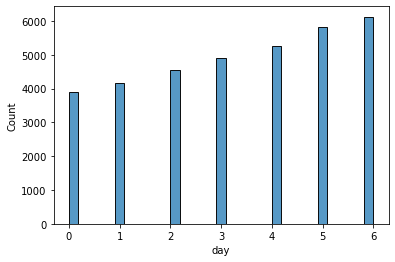

In [403]:
sns.histplot(data, x="day")

<AxesSubplot:xlabel='day', ylabel='is_correct'>

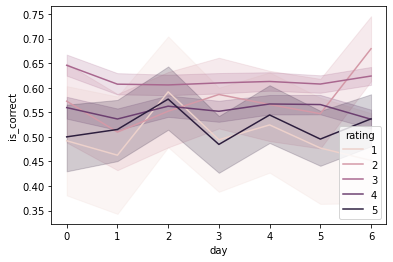

In [404]:
sns.lineplot(data, x="day", y="is_correct", hue="rating")

<AxesSubplot:xlabel='day', ylabel='is_correct'>

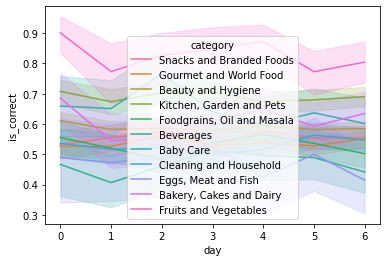

In [405]:
sns.lineplot(data, x="day", y="is_correct", hue="category")

In [406]:
data.groupby("rating")["is_correct"].mean()

rating
1    0.497418
2    0.576923
3    0.615385
4    0.554112
5    0.521831
Name: is_correct, dtype: float64

In [407]:
data.groupby("category")["is_correct"].mean()

category
Baby Care                     0.644979
Bakery, Cakes and Dairy       0.611849
Beauty and Hygiene            0.587767
Beverages                     0.469052
Cleaning and Household        0.530760
Eggs, Meat and Fish           0.473684
Foodgrains, Oil and Masala    0.527950
Fruits and Vegetables         0.827770
Gourmet and World Food        0.537816
Kitchen, Garden and Pets      0.690185
Snacks and Branded Foods      0.552274
Name: is_correct, dtype: float64